It may be possible to extract the particle energies from some tracks by analyzing their dE/dx.

This can be done by selecting long tracks (threshold TBD) and just making a histogram over their nonzero pixels and then fitting a distro.

However, the energy/sample is not just dE/dx, it is instead very angle dependent, due to the shape of our samples (pixel shape and binning).

So, we must essentially recover dE/sample and sample/dx(alpha,theta)

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from analysis_funcs import *

The following functions extract the dE/dx - for the development of them, see below

In [22]:
def linefunc(pars, x):
    """
    pars is an array of [theta,y0], with theta given in degrees
    """
    return np.tan(pars[0]*np.pi/180)*x + pars[1]

def angle_linefit(track, pixratio=1):
    """
    Determine the angle of the track with respect to axis 0.
    In case of non-quadratic pixels, pixratio gives the ratio of pixel lengths in axis 1 to axis 0 
    (so in case of Gaia, AC/AL including binnning)
    """
    
    dim0, dim1 = track.shape
    
    # we will form an x/y value pairs
    # the for the shorter axis (Gaia: Usually AC, so y), we calculate the center of mass at each value of the longer axis
    
    from scipy.ndimage.measurements import center_of_mass
    
    if dim0 >= dim1:
        labels = np.zeros((dim0,dim1)) + np.transpose(np.array([range(dim0)]))
        cms = (center_of_mass(track, labels, range(dim0)))
        if dim1==1:
            # add a little scatter to dim1
            yvals = (np.random.random(dim0)-0.5)*0.01
            cms = [(cms[ii][0],yvals[ii]) for ii in range(dim0)]                
    else:
        labels = np.zeros((dim0,dim1)) + np.array([range(dim1)])
        cms = (center_of_mass(track, labels, range(dim1)))
        if dim0==1:
            # add a little scatter to dim0
            xvals = (np.random.random(dim1)-0.5)*0.01
            cms = [(xvals[ii],cms[ii][1]) for ii in range(dim1)]
                
    x = np.array([c[0] for c in cms])
    y = np.array([c[1] for c in cms])* pixratio
    
    # TODO erros should be calculated more intelligently
    dx = np.zeros(x.shape)+0.5
    dy = np.zeros(y.shape)+pixratio/2

    
    from scipy import odr
    
    linemodel = odr.Model(linefunc)
    fitdat = odr.RealData(x, y, sx=dx, sy=dy)

    myodr = odr.ODR(fitdat, linemodel, beta0=[0., 0.])
    myoutput = myodr.run()
    
    #plt.errorbar(x,y,xerr=dx,yerr=dy)
    return myoutput.beta[0], myoutput.sd_beta[0]

def sample_distance(theta, bin_AL, bin_AC):
    thetacrit = np.arctan(3*bin_AC / (bin_AL))

    if np.abs(theta) <= thetacrit:
        return 10 * bin_AL / np.cos(np.abs(theta))
    else:
        return 30 * bin_AC / np.sin(np.abs(theta))
    

def track_dE_dx(flat_track, gain, dim_AL, dim_AC, bin_AL, bin_AC):
    """
    Recover dE/dx from a flattened cosmic ray track in units of MeV cm^2/g
    """
    track = np.reshape(flat_track,(dim_AL,dim_AC))*obslist[iobs].gain
        
    theta = angle_linefit(track, 3*bin_AC/bin_AL)[0]*np.pi/180
    print('theta:',theta*180/np.pi)
    
    dx = sample_distance(theta, bin_AL, bin_AC)
    
    # dE/dx = Measured electrons * e/h pair creation energy / dx -> eV / mum
    # converting to MeV cm^2/g then requires a factor 10^-2 and dividing by density
    
    return track[track>0]*3.68/dx/100/2.32
                 

In [4]:
# SM
obslist = read_Obslist_fits('../output/2016/12/07/SM-SIF_OBMT_START_98084005999790300.fits')
bin_AL = 2
bin_AC = 2

# BAM
#obslist = read_Obslist_fits('../analysis/bam/output/2017-07-03/BAM-OBS1_OBMT_START_115999323050548704.fits')
#bin_AL = 1
#bin_AC = 4

# BAM-SIF
#obslist = read_Obslist_fits('../analysis/bam_sif/output/BAM-SIF1_2014.fits')
#bin_AL = 1
#bin_AC = 4

print('Nr. Observations:',len(obslist))

Nr. Observations: 150


In [14]:
longobs = []

for ii in range(len(obslist)):
    if (len(obslist[ii].data) == 0):
        continue
    trackpix = np.array([np.sum(t>0) for t in obslist[ii].data['TRACK']])
    valids = np.max(trackpix)
    if valids >=100 and valids<1000:
    #if valids >=40:
        longobs.append(ii)

print('Nr. interesting observations:', len(longobs))

Nr. interesting observations: 2


In [24]:
iobs = longobs[1]

#itrack = np.argmax(np.sqrt((20*obslist[iobs].data['DIM_AL'])**2 + (60*obslist[iobs].data['DIM_AC'])**2))
#itrack = np.argmax(obslist[iobs].data['DIM_AL'])
itrack = np.argmax([np.sum(t>0) for t in obslist[iobs].data['TRACK']])

print("Nr. of samples:",np.sum(obslist[iobs].data[itrack]['TRACK']>0))

Nr. of samples: 174


Track Energy: 1074936
Per pixel: 6177.79310345


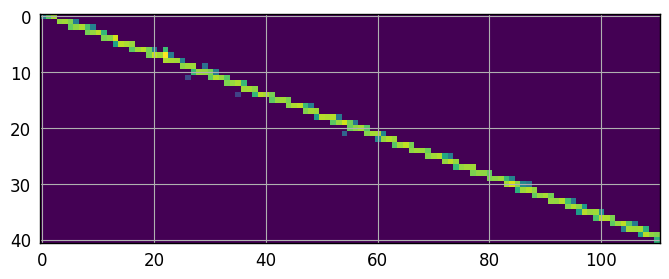

In [25]:
# view the track

track = np.reshape(obslist[iobs].data[itrack]['TRACK'],
                 (obslist[iobs].data[itrack]['DIM_AL'],obslist[iobs].data[itrack]['DIM_AC']))*obslist[iobs].gain

plt.imshow(np.rot90(track+1), norm=LogNorm())

print("Track Energy:", obslist[iobs].data[itrack]['TRACK_EN'])
print("Per pixel:", obslist[iobs].data[itrack]['TRACK_EN']/np.sum(obslist[iobs].data[itrack]['TRACK']>0))

theta: -47.306530823
Mean (Excluding below 0.5): 4.04741320831
MIP: 1.664


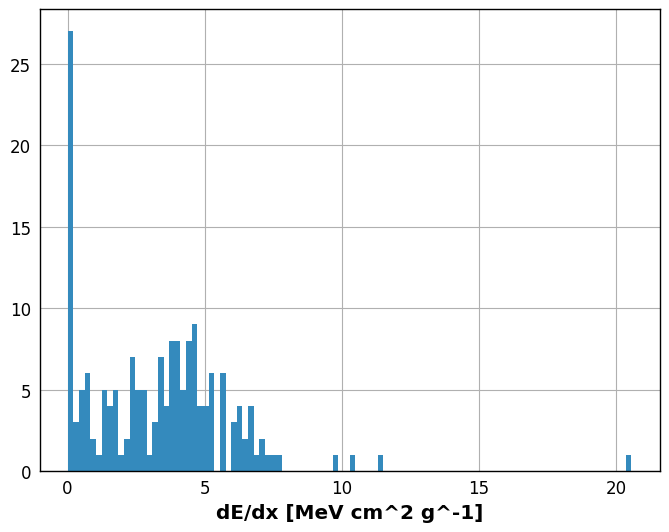

In [26]:
dE_dx = track_dE_dx(obslist[iobs].data[itrack]['TRACK'],obslist[iobs].gain,
                    obslist[iobs].data[itrack]['DIM_AL'],obslist[iobs].data[itrack]['DIM_AC'],
                    bin_AL, bin_AC)

testhist = plt.hist(dE_dx,100)

plt.xlabel("dE/dx [MeV cm^2 g^-1]")

print("Mean (Excluding below 0.5):",np.mean(dE_dx[dE_dx > .5]))
print("MIP:",1.664)

In [438]:
388/100/2.32

1.6724137931034484

In [439]:
obs = obslist[iobs]

 # Code step for step

To get the correct geometry, try to unbin the the track

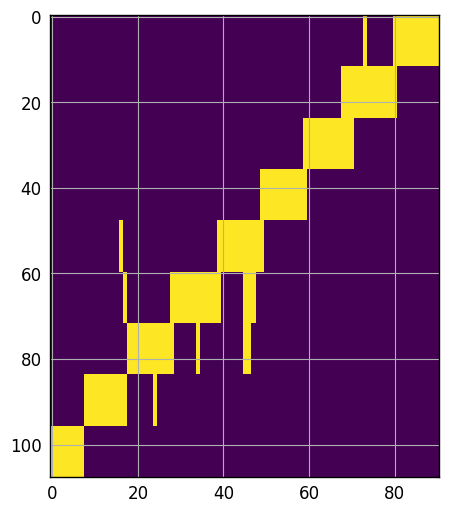

In [73]:
piximg = unbin(track,bin_AL,bin_AC*3)

plt.imshow(np.rot90(piximg>0))

In this case, we reverse the binning and just distribute the average of all energies onto 10x10 $\mu$m subpixels

From this thing, we should be able to determine the angles...

In [74]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

h, th, d = hough_line(piximg)

theta = hough_line_peaks(h, th, d)[1][0] # may need to be smarter about picking the peak here

print(theta* 180/np.pi)

-49.7765363128


In [75]:
np.arctan(piximg.shape[1]/piximg.shape[0])*180/np.pi

49.882759563833055

-> The angle from my approximation and the hugh transform seem to be similar, but I don't pick up the sign. The breakdown point is probably for smaller tracks.

To get the distance in the sample, there are some boundary cases:

- The cosmic crosses AL entirely, but not AC

- The cosmic crosses AC entirely, but not AL

There is also the inbetween case of the cosmic crossing the sample in AL and AC exactly. This is at the angle

$\theta_\mathrm{crit} = \arctan \frac{3 ~ \mathrm{binAC}}{1 ~ \mathrm{binAL}}$

Then:
 - if $|\theta| < \theta_\mathrm{crit}$: AL is crossed entirely, $l = \frac{10\, \mu m \cdot binAL}{\cos(\theta)}$
 - if $|\theta| > \theta_\mathrm{crit}$: AC is crossed entirely, $l = \frac{30\, \mu m \cdot binAC}{\sin(\theta)}$

In [76]:
thetacrit = np.arctan(3*bin_AC / (bin_AL))

if np.abs(theta) <= thetacrit:
    sampdist = 10 * bin_AL / np.cos(np.abs(theta))
else:
    sampdist = 30 * bin_AC / np.sin(np.abs(theta))

In [77]:
thetacrit*180/np.pi

85.236358309273825

In [78]:
theta*180/np.pi

-49.776536312849167

In [79]:
print(sampdist)
print(np.sqrt(sampdist**2 + 4**2))

15.4853794091
15.9936542242


For long tracks, the depth crossed does not matter

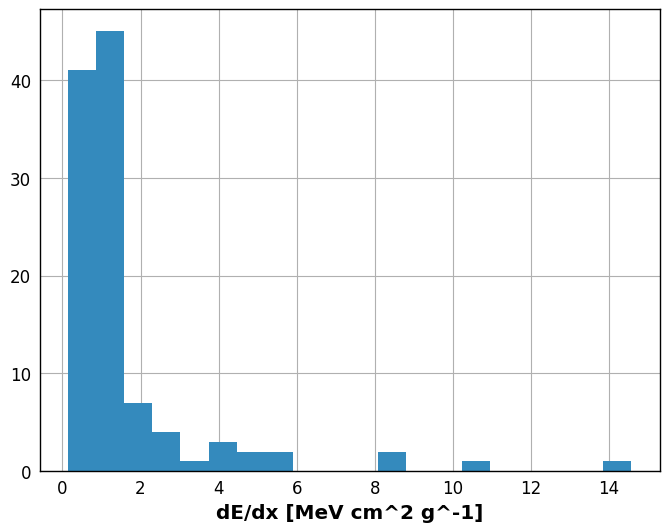

In [80]:
testhist = plt.hist(track[track>0]*3.68/sampdist/100/2.32,20)

plt.xlabel("dE/dx [MeV cm^2 g^-1]")

In [24]:
print(np.median(track[track>0]*3.6/sampdist/100/2.32))

1.04243081377
